In [ ]:
# Import data from file into dataframe
import pandas as pd
import io
df = pd.read_csv('Tic_Tac_Toe.csv', names=["TL", "TM", "TR", "ML", "MM", "MR", "BL", "BM", "BR", "can_win"])
# Dataset is now stored in a Pandas Dataframe
df.head()

,TL,TM,TR,ML,MM,MR,BL,BM,BR,can_win
0,x,x,x,x,o,o,x,o,o,positive
1,x,x,x,x,o,o,o,x,o,positive
2,x,x,x,x,o,o,o,o,x,positive
3,x,x,x,x,o,o,o,b,b,positive
4,x,x,x,x,o,o,b,o,b,positive


In [ ]:
df.describe()

,TL,TM,TR,ML,MM,MR,BL,BM,BR,can_win
count,958,958,958,958,958,958,958,958,958,958
unique,3,3,3,3,3,3,3,3,3,2
top,x,x,x,x,x,x,x,x,x,positive
freq,418,378,418,378,458,378,418,378,418,626


<Axes: xlabel='can_win', ylabel='count'>

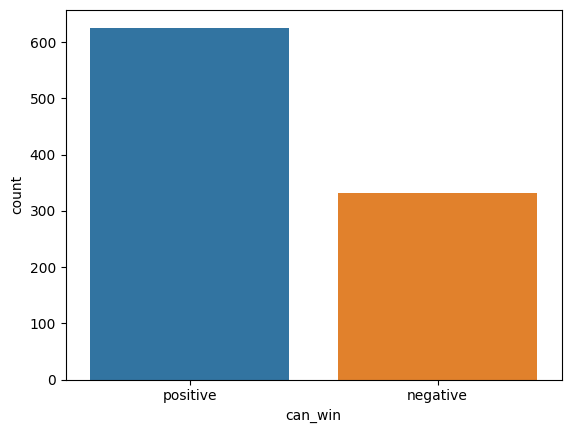

In [ ]:
import seaborn as sns
sns.countplot(x="can_win", data=df)
# Shows more positve outcomes than negative outcomes

In [ ]:
# Description of types of data
df.info()
# No null values found

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958 entries, 0 to 957
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   TL       958 non-null    object
 1   TM       958 non-null    object
 2   TR       958 non-null    object
 3   ML       958 non-null    object
 4   MM       958 non-null    object
 5   MR       958 non-null    object
 6   BL       958 non-null    object
 7   BM       958 non-null    object
 8   BR       958 non-null    object
 9   can_win  958 non-null    object
dtypes: object(10)
memory usage: 75.0+ KB


In [ ]:
# Marking {x:2 , o:1 , b:0}
# Marking outcome {positive:1 , negative:0}
for column in df:
  df[column]=df[column].astype('category').cat.codes


df.head()

,TL,TM,TR,ML,MM,MR,BL,BM,BR,can_win
0,2,2,2,2,1,1,2,1,1,1
1,2,2,2,2,1,1,1,2,1,1
2,2,2,2,2,1,1,1,1,2,1
3,2,2,2,2,1,1,1,0,0,1
4,2,2,2,2,1,1,0,1,0,1


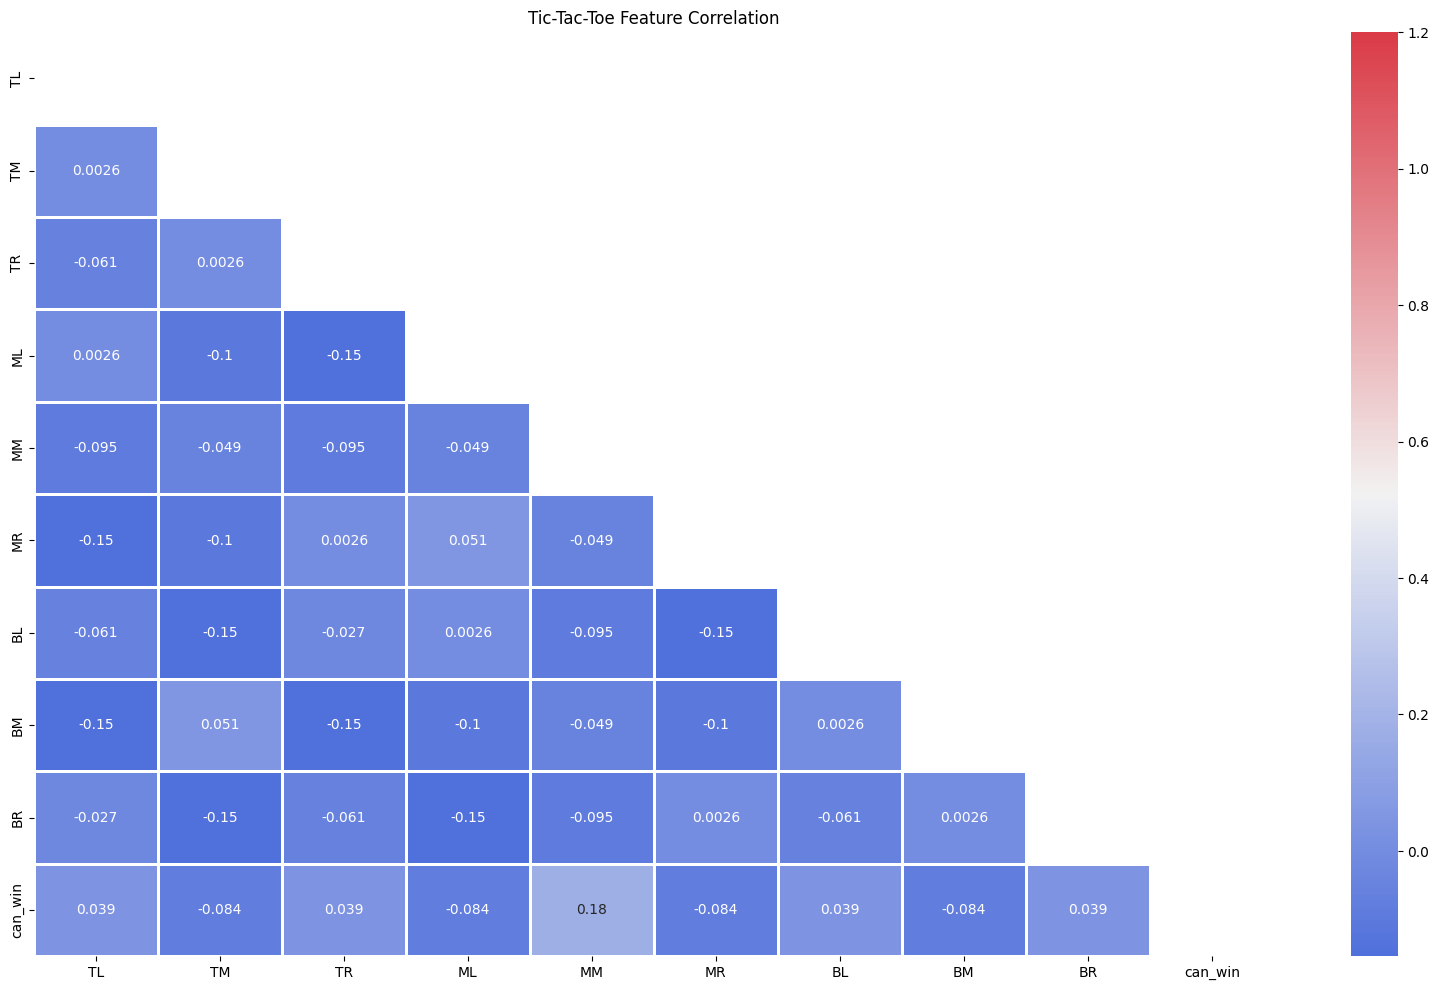

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# Correlation matrix
corrMatt = df.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corrMatt)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(20, 12))
plt.title('Tic-Tac-Toe Feature Correlation')
# Generate a custom diverging colormap
cmap = sns.diverging_palette(260, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corrMatt, vmax=1.2, square=False, cmap=cmap, mask=mask,ax=ax, annot=True, fmt='.2g', linewidths=1);

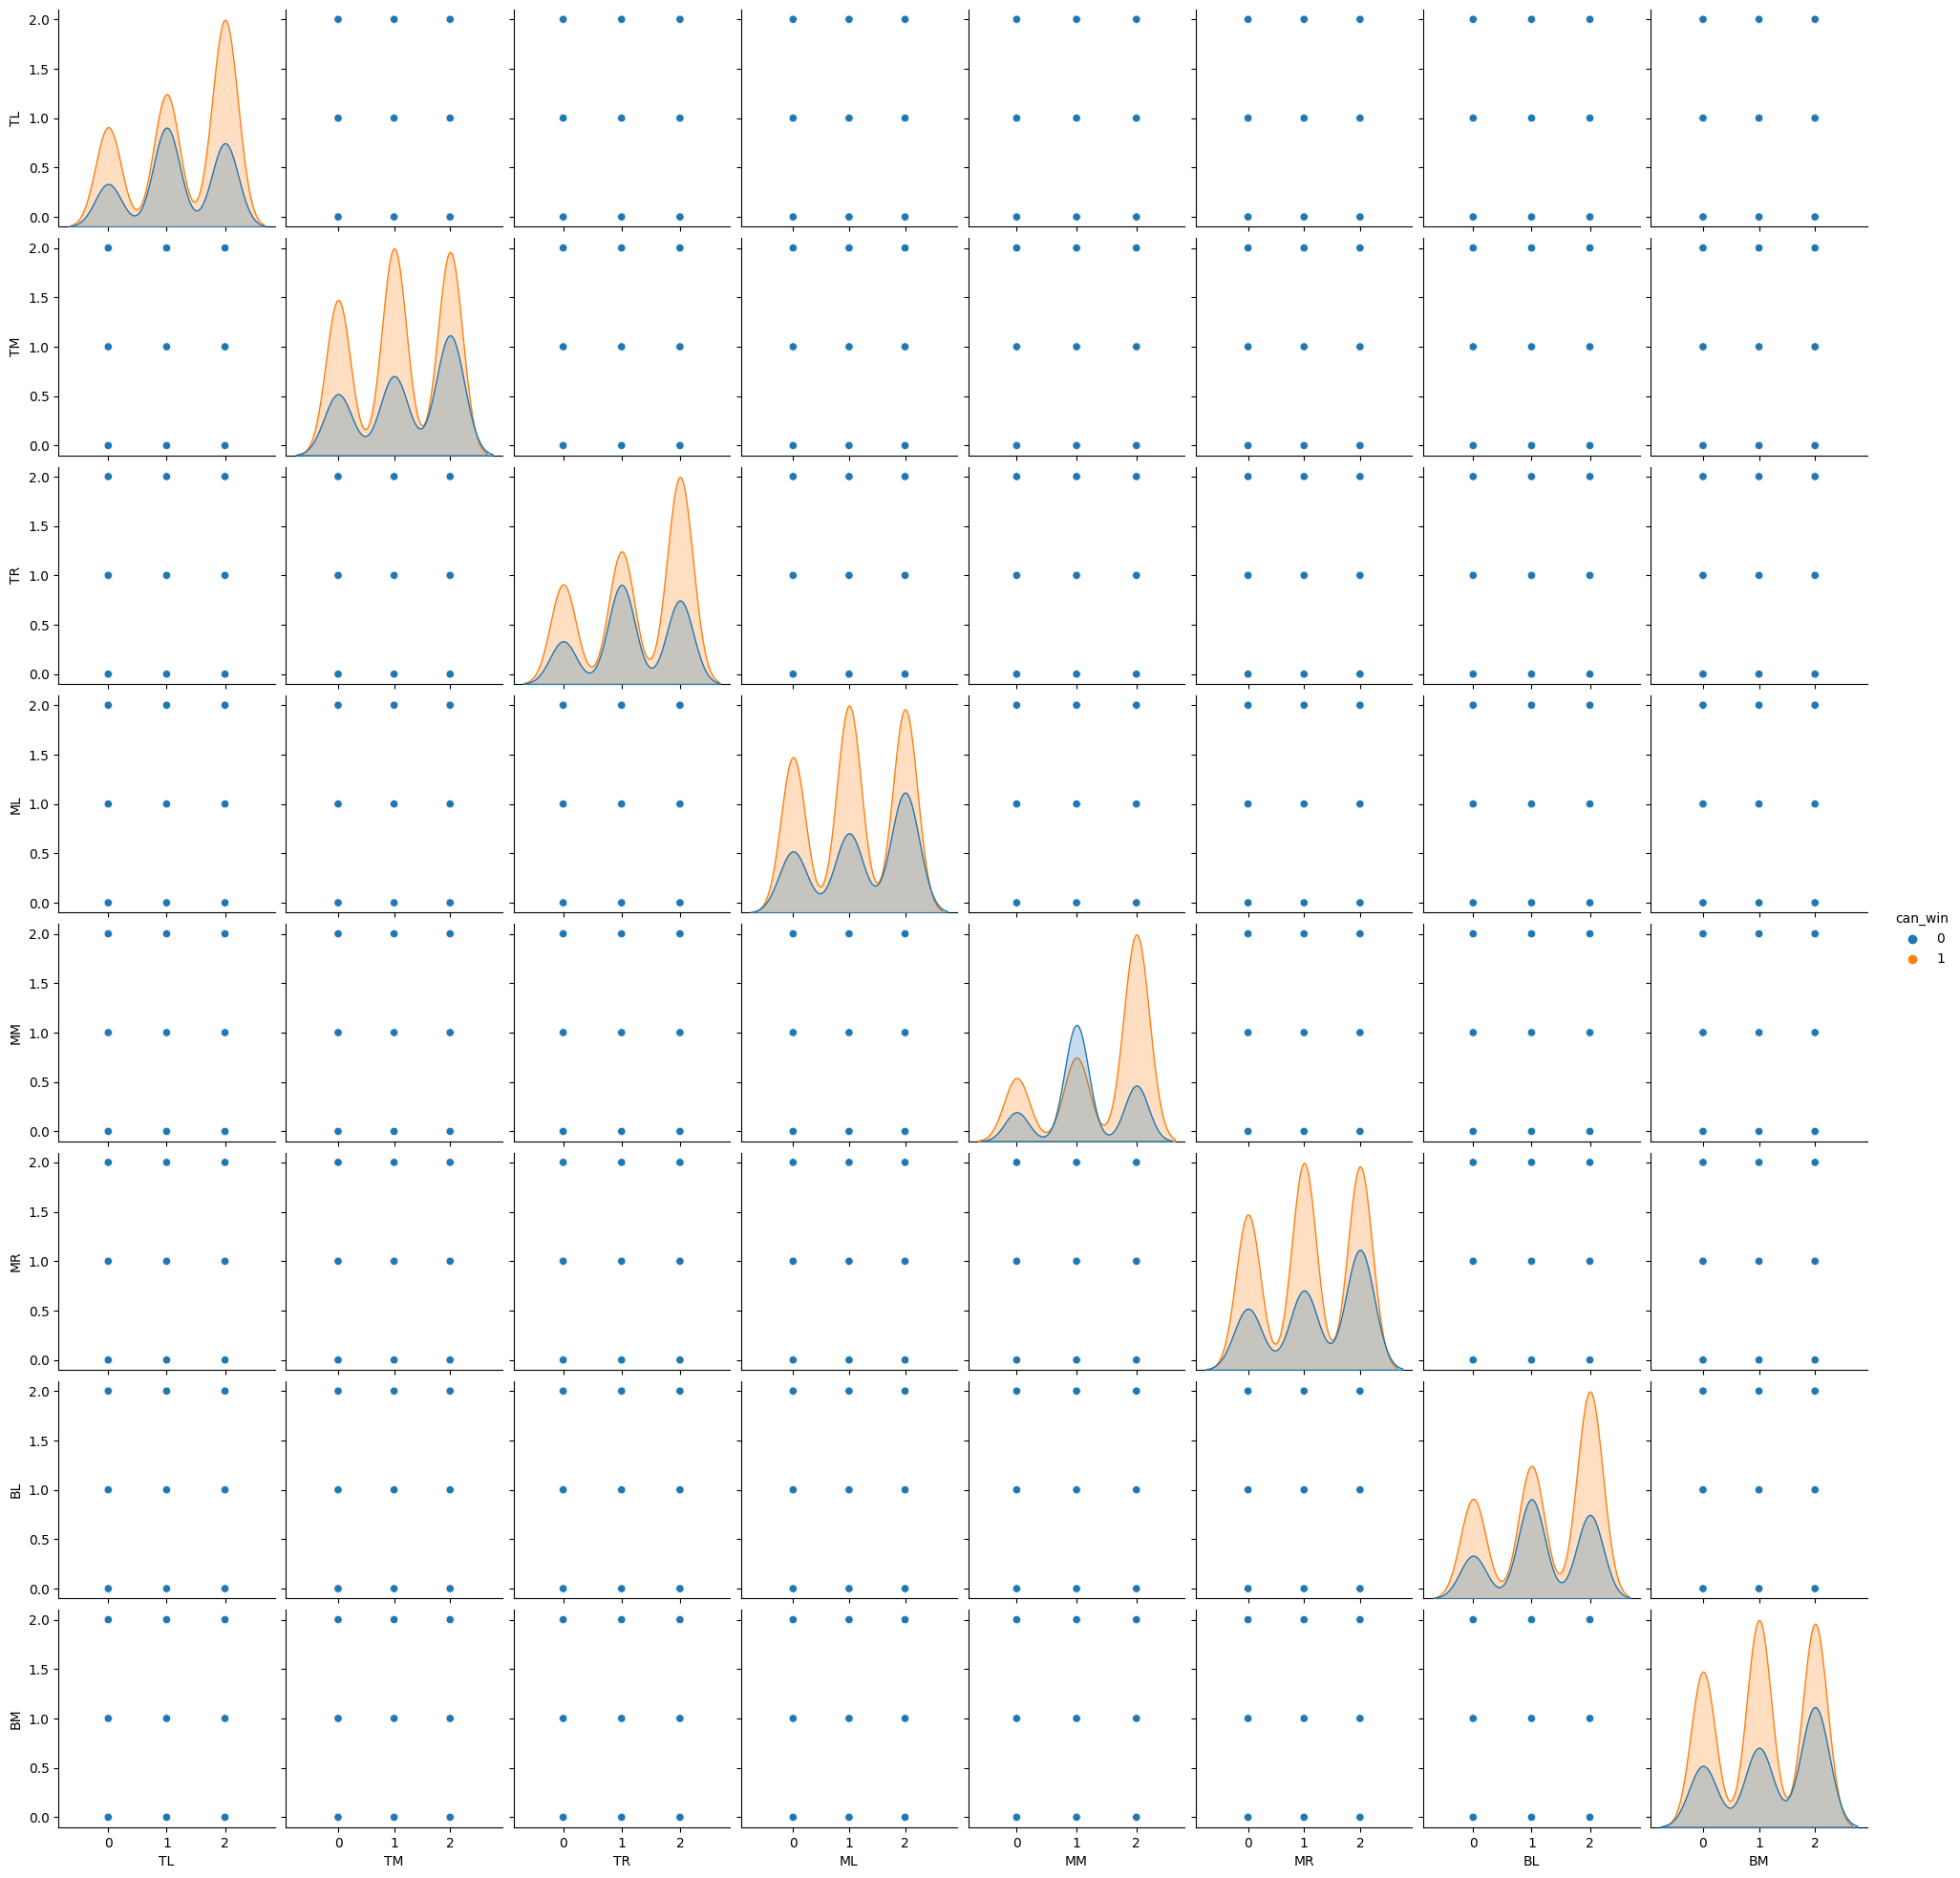

In [ ]:
sns.pairplot(df[list(df.columns[0:8]) + ['can_win']], hue="can_win");

In [ ]:
# Print shape of the matrix to ensure uploaded correctly
df.shape

(958, 10)

In [ ]:
# Split data into inputs and outputs
# Shuffle the datafram makes it better for k-fold to evaluate due to the structured nature of our dataset
shuffled_df = df.sample(frac=1).reset_index(drop=True)
y = shuffled_df['can_win']
X = shuffled_df.drop('can_win', axis=1)

**Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Define the hyperparameters to tune
param_grid = {
    'C': np.logspace(-4, 4, 20),  # A logarithmic grid of values for C
    'penalty': ['l1', 'l2'],      # Regularization penalties
    'solver': ['liblinear']        # 'liblinear' works well for small datasets and supports both l1 and l2
}

# Initialize the Logistic Regression classifier
logreg = LogisticRegression()

# Set up cross-validation for hyperparameter tuning
grid_search = GridSearchCV(logreg, param_grid, cv=StratifiedKFold(n_splits=5), scoring='accuracy', n_jobs=-1)

testing_scores = []
training_scores = []
fold_num = 0;
for train, test in StratifiedKFold(n_splits=5).split(X, y):
    fold_num =+ 1
    x_tr, x_te, y_tr, y_te = X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test]

    # Perform the grid search to find the best hyperparameters for the training + {internal} validation set
    grid_search.fit(x_tr, y_tr)

    # Now can use the best parameters to perform k-fold cross-validation
    best_logreg = grid_search.best_estimator_

    # Output the best parameters and the corresponding accuracy for those parameters
    best_params = grid_search.best_params_
    best_accuracy = grid_search.best_score_
    print(f"Best parameters for fold {fold_num}: {best_params}")
    print(f"Best test accuracy from GridSearchCV for fold {fold_num}: {best_accuracy:.2f}")


    # Evaluate the model on training and testing
    training_accuracy = best_logreg.score(x_tr, y_tr)
    testing_accuracy = best_logreg.score(x_te, y_te)
    training_variance = np.var(best_logreg.predict(x_tr) == y_tr)
    testing_variance = np.var(best_logreg.predict(x_te) == y_te)

    # Store the scores
    training_scores.append(training_accuracy)
    testing_scores.append(testing_accuracy)

    # Make predictions and print out the classification report
    y_pred = best_logreg.predict(X.iloc[test])
    print(f'The classifier testing accuracy for fold {fold_num} is: {testing_accuracy:.2f}')
    # Print the variance for this fold
    print(f"Training variance for fold {fold_num}: {training_variance:.4f}")
    print(f"Testing variance for fold {fold_num}: {testing_variance:.4f}")
    # Print report
    print(classification_report(y.iloc[test], y_pred, target_names=['loss', 'win']))

# Print the average training and testing scores with standard deviation
print("OVERALL Training scores:", training_scores)
print("OVERALL Testing scores:", testing_scores)
avg_training = (100 * np.mean(training_scores), 100 * np.std(training_scores)/np.sqrt(len(training_scores)))
avg_testing = (100 * np.mean(testing_scores), 100 * np.std(testing_scores)/np.sqrt(len(testing_scores)))
print(f"Average training accuracy and standard deviation: ({avg_training[0]:.2f} +- {avg_training[1]:.3f})%")
print(f"Average testing accuracy and standard deviation: ({avg_testing[0]:.2f} +- {avg_testing[1]:.3f})%")
# Best parameters given were {'C': 0.23357214690901212, 'penalty': 'l2', 'solver': 'liblinear'}

Best parameters for fold 1: {'C': 0.23357214690901212, 'penalty': 'l2', 'solver': 'liblinear'}
Best test accuracy from GridSearchCV for fold 1: 0.68
The classifier testing accuracy for fold 1 is: 0.73
Training variance for fold 1: 0.2161
Testing variance for fold 1: 0.1975
              precision    recall  f1-score   support

        loss       0.75      0.32      0.45        66
         win       0.73      0.94      0.82       126

    accuracy                           0.73       192
   macro avg       0.74      0.63      0.63       192
weighted avg       0.73      0.73      0.69       192

Best parameters for fold 1: {'C': 0.23357214690901212, 'penalty': 'l2', 'solver': 'liblinear'}
Best test accuracy from GridSearchCV for fold 1: 0.70
The classifier testing accuracy for fold 1 is: 0.70
Training variance for fold 1: 0.2075
Testing variance for fold 1: 0.2108
              precision    recall  f1-score   support

        loss       0.70      0.24      0.36        67
         win    

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np

# Best parameters from previous tuning
best_params = {'C': 0.23357214690901212, 'penalty': 'l2', 'solver': 'liblinear'}

# Initialize the Logistic Regression classifier with the best parameters
logreg_best = LogisticRegression(C=best_params['C'], penalty=best_params['penalty'], solver=best_params['solver'])

# Set up k-fold cross-validation
kfold = StratifiedKFold(n_splits=5)

# Perform k-fold cross-validation to get the accuracy for each fold
accuracies = cross_val_score(logreg_best, X, y, cv=kfold, scoring='accuracy')

# Calculate mean accuracy and variance
mean_accuracy = np.mean(accuracies)
variance = np.var(accuracies)

# Print the results
print("Accuracies: ", accuracies)
print(f"Mean k-fold accuracy: {mean_accuracy:0.9f}")
print(f"Variance of k-fold accuracies: {variance:0.9f}")

Accuracies:  [0.72916667 0.69791667 0.69270833 0.72251309 0.64921466]
Mean k-fold accuracy: 0.698303883
Variance of k-fold accuracies: 0.000795962


**Support Vector Machine**

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Define the hyperparameters to tune for SVM
param_grid = {
    'C': np.logspace(-4, 4, 20),          # A logarithmic grid of values for C
    'kernel': ['linear', 'rbf'],           # Kernel types to try
    'gamma': ['scale', 'auto']             # Kernel coefficient for 'rbf', 'poly' and 'sigmoid'
}

# Initialize the Support Vector Classifier
svc = SVC()

# Set up cross-validation for hyperparameter tuning
grid_search = GridSearchCV(svc, param_grid, cv=StratifiedKFold(n_splits=5), scoring='accuracy', n_jobs=-1)

testing_scores = []
training_scores = []
fold_num = 0;
for train, test in StratifiedKFold(n_splits=5).split(X, y):
    fold_num =+ 1
    x_tr, x_te, y_tr, y_te = X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test]

    # Perform the grid search to find the best hyperparameters for the training + {internal} validation set
    grid_search.fit(x_tr, y_tr)

    # Now can use the best parameters to perform k-fold cross-validation
    best_svc = grid_search.best_estimator_

    # Output the best parameters and the corresponding accuracy
    best_params = grid_search.best_params_
    best_accuracy = grid_search.best_score_
    print(f"Best parameters for fold {fold_num}: {best_params}")
    print(f"Best test accuracy from GridSearchCV for fold {fold_num}: {best_accuracy:.2f}")


    # Evaluate the model
    training_accuracy = best_svc.score(x_tr, y_tr)
    testing_accuracy = best_svc.score(x_te, y_te)
    training_variance = np.var(best_svc.predict(x_tr) == y_tr)
    testing_variance = np.var(best_svc.predict(x_te) == y_te)

    # Store the scores
    training_scores.append(training_accuracy)
    testing_scores.append(testing_accuracy)

    # Make predictions and print out the classification report
    y_pred = best_svc.predict(X.iloc[test])
    print(f'The classifier testing accuracy for fold {fold_num} is: {testing_accuracy:.2f}')
    # Print the variance for this fold
    print(f"Training variance for fold {fold_num}: {training_variance:.4f}")
    print(f"Testing variance for fold {fold_num}: {testing_variance:.4f}")
    # Print report
    print(classification_report(y.iloc[test], y_pred, target_names=['loss', 'win']))

# Print the average training and testing scores with standard deviation
print("OVERALL Training scores:", training_scores)
print("OVERALL Testing scores:", testing_scores)
avg_training = (100 * np.mean(training_scores), 100 * np.std(training_scores)/np.sqrt(len(training_scores)))
avg_testing = (100 * np.mean(testing_scores), 100 * np.std(testing_scores)/np.sqrt(len(testing_scores)))
print(f"Average training accuracy and standard deviation: ({avg_training[0]:.2f} +- {avg_training[1]:.3f})%")
print(f"Average testing accuracy and standard deviation: ({avg_testing[0]:.2f} +- {avg_testing[1]:.3f})%")
# Best parameters given were {'C': 78.47599703514607, 'gamma': 'auto', 'kernel': 'rbf'}

Best parameters for fold 1: {'C': 78.47599703514607, 'gamma': 'auto', 'kernel': 'rbf'}
Best test accuracy from GridSearchCV for fold 1: 0.99
The classifier testing accuracy for fold 1 is: 1.00
Training variance for fold 1: 0.0000
Testing variance for fold 1: 0.0000
              precision    recall  f1-score   support

        loss       1.00      1.00      1.00        66
         win       1.00      1.00      1.00       126

    accuracy                           1.00       192
   macro avg       1.00      1.00      1.00       192
weighted avg       1.00      1.00      1.00       192

Best parameters for fold 1: {'C': 78.47599703514607, 'gamma': 'auto', 'kernel': 'rbf'}
Best test accuracy from GridSearchCV for fold 1: 0.99
The classifier testing accuracy for fold 1 is: 0.99
Training variance for fold 1: 0.0000
Testing variance for fold 1: 0.0103
              precision    recall  f1-score   support

        loss       1.00      0.97      0.98        67
         win       0.98      1.0

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np

# Best parameters from previous tuning
best_params = {'C': 78.47599703514607, 'gamma': 'auto', 'kernel': 'rbf'}

# Initialize the Support Vector Classifier with the best parameters
svc_best = SVC(C=best_params['C'], gamma=best_params['gamma'], kernel=best_params['kernel'])

# Set up k-fold cross-validation
kfold = StratifiedKFold(n_splits=5)

# Perform k-fold cross-validation to get the accuracy for each fold
accuracies = cross_val_score(svc_best, X, y, cv=kfold, scoring='accuracy')

# Calculate mean accuracy and variance
mean_accuracy = np.mean(accuracies)
variance = np.var(accuracies)

# Print the results
print("Accuracies: ", accuracies)
print(f"Mean k-fold accuracy: {mean_accuracy:0.9f}")
print(f"Variance of k-fold accuracies: {variance:0.9f}")


Accuracies:  [1.         0.98958333 1.         0.9947644  1.        ]
Mean k-fold accuracy: 0.996869546
Variance of k-fold accuracies: 0.000017384


**Decision Tree Classifier**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Define the hyperparameters to tune for Decision Tree
param_grid = {
    'max_depth': range(1, 11)  # Range of values for max_depth from 1 to 10
}

# Initialize the Decision Tree Classifier
dtree = DecisionTreeClassifier()

# Set up cross-validation for hyperparameter tuning
grid_search = GridSearchCV(dtree, param_grid, cv=StratifiedKFold(n_splits=5), scoring='accuracy', n_jobs=-1)

testing_scores = []
training_scores = []
fold_num = 0
for train, test in StratifiedKFold(n_splits=5).split(X, y):
    fold_num =+ 1
    x_tr, x_te, y_tr, y_te = X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test]

    # Perform the grid search to find the best hyperparameters for the training + {internal} validation set
    grid_search.fit(x_tr, y_tr)

    # Now can use the best parameters to perform k-fold cross-validation
    best_dtree = grid_search.best_estimator_

    # Output the best parameters and the corresponding accuracy
    best_params = grid_search.best_params_
    best_accuracy = grid_search.best_score_
    print(f"Best parameters for fold {fold_num}: {best_params}")
    print(f"Best test accuracy from GridSearchCV for fold {fold_num}: {best_accuracy:.2f}")

    # Evaluate the model
    training_accuracy = best_dtree.score(x_tr, y_tr)
    testing_accuracy = best_dtree.score(x_te, y_te)
    training_variance = np.var(best_dtree.predict(x_tr) == y_tr)
    testing_variance = np.var(best_dtree.predict(x_te) == y_te)

    # Store the scores
    training_scores.append(training_accuracy)
    testing_scores.append(testing_accuracy)

    # Make predictions and print out the classification report
    y_pred = best_dtree.predict(x_te)
    print(f'The classifier testing accuracy for fold {fold_num} is: {testing_accuracy:.2f}')

    # Print the variance for this fold
    print(f"Training variance for fold {fold_num}: {training_variance:.4f}")
    print(f"Testing variance for fold {fold_num}: {testing_variance:.4f}")

    # Print report
    print(classification_report(y_te, y_pred, target_names=['loss', 'win']))

# Print the average training and testing scores with standard deviation
print("OVERALL Training scores:", training_scores)
print("OVERALL Testing scores:", testing_scores)
avg_training = (100 * np.mean(training_scores), 100 * np.std(training_scores)/np.sqrt(len(training_scores)))
avg_testing = (100 * np.mean(testing_scores), 100 * np.std(testing_scores)/np.sqrt(len(testing_scores)))
print(f"Average training accuracy and standard deviation: ({avg_training[0]:.2f} +- {avg_training[1]:.3f})%")
print(f"Average testing accuracy and standard deviation: ({avg_testing[0]:.2f} +- {avg_testing[1]:.3f})%")
# Best parameters given were {'max_depth': 10}

Best parameters for fold 1: {'max_depth': 9}
Best test accuracy from GridSearchCV for fold 1: 0.86
The classifier testing accuracy for fold 1 is: 0.88
Training variance for fold 1: 0.0179
Testing variance for fold 1: 0.1054
              precision    recall  f1-score   support

        loss       0.91      0.73      0.81        66
         win       0.87      0.96      0.91       126

    accuracy                           0.88       192
   macro avg       0.89      0.84      0.86       192
weighted avg       0.88      0.88      0.88       192

Best parameters for fold 1: {'max_depth': 10}
Best test accuracy from GridSearchCV for fold 1: 0.88
The classifier testing accuracy for fold 1 is: 0.82
Training variance for fold 1: 0.0052
Testing variance for fold 1: 0.1491
              precision    recall  f1-score   support

        loss       0.75      0.72      0.73        67
         win       0.85      0.87      0.86       125

    accuracy                           0.82       192
   mac

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np

# Best parameters from previous tuning
best_params = {'max_depth': 10}

# Initialize the Decision Tree Classifier with the best parameters
dtree_best = DecisionTreeClassifier(max_depth=best_params['max_depth'])

# Set up k-fold cross-validation
kfold = StratifiedKFold(n_splits=5)

# Perform k-fold cross-validation to get the accuracy for each fold
accuracies = cross_val_score(dtree_best, X, y, cv=kfold, scoring='accuracy')

# Calculate mean accuracy and variance
mean_accuracy = np.mean(accuracies)
variance = np.var(accuracies)

# Print the results
print("Accuracies: ", accuracies)
print(f"Mean k-fold accuracy: {mean_accuracy:.09f}")
print(f"Variance of k-fold accuracies: {variance:.09f}")

Accuracies:  [0.88020833 0.84895833 0.859375   0.85340314 0.90052356]
Mean k-fold accuracy: 0.868493674
Variance of k-fold accuracies: 0.000371130


**Artificial Neural Networks**

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Define the hyperparameters to tune for ANN
param_grid = {
    'hidden_layer_sizes': [(5,), (10,), (50,), (5,5), (10,10), (50,50)],
    'activation': ['tanh', 'relu'],                            # Activation functions
    'solver': ['sgd', 'adam'],                                 # Optimization algorithms
    'alpha': np.logspace(-5, 3, 5),                            # L2 penalty (regularization term) parameter
    'learning_rate': ['constant','adaptive'],                  # Learning rate schedule
}

# Initialize the Artificial Neural Network Classifier
ann = MLPClassifier(max_iter=3000)  # Increased max_iter for convergence

# Set up cross-validation for hyperparameter tuning
grid_search = GridSearchCV(ann, param_grid, cv=StratifiedKFold(n_splits=5), scoring='accuracy', n_jobs=-1)

testing_scores = []
training_scores = []
fold_num = 0
for train, test in StratifiedKFold(n_splits=5).split(X, y):
    fold_num =+ 1
    x_tr, x_te, y_tr, y_te = X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test]

    # Perform the grid search to find the best hyperparameters for the training + {internal} validation set
    grid_search.fit(x_tr, y_tr)

    # Now you can use the best parameters to perform your k-fold cross-validation
    best_ann = grid_search.best_estimator_

    # Output the best parameters and the corresponding accuracy
    best_params = grid_search.best_params_
    best_accuracy = grid_search.best_score_

    print(f"Best parameters for fold {fold_num}: {best_params}")
    print(f"Best test accuracy from GridSearchCV for fold {fold_num}: {best_accuracy:.2f}")

    # Evaluate the model
    training_accuracy = best_ann.score(x_tr, y_tr)
    testing_accuracy = best_ann.score(x_te, y_te)
    training_variance = np.var(best_ann.predict(x_tr) == y_tr)
    testing_variance = np.var(best_ann.predict(x_te) == y_te)

    # Store the scores
    training_scores.append(training_accuracy)
    testing_scores.append(testing_accuracy)

    # Make predictions and print out the classification report
    y_pred = best_ann.predict(x_te)
    print(f'The classifier testing accuracy for fold {fold_num} is: {testing_accuracy:.2f}')

    # Print the variance for this fold
    print(f"Training variance for fold {fold_num}: {training_variance:.4f}")
    print(f"Testing variance for fold {fold_num}: {testing_variance:.4f}")

    # Print report
    print(classification_report(y_te, y_pred, target_names=['loss', 'win']))

# Print the average training and testing scores with standard deviation
print("OVERALL Training scores:", training_scores)
print("OVERALL Testing scores:", testing_scores)
avg_training = (100 * np.mean(training_scores), 100 * np.std(training_scores)/np.sqrt(len(training_scores)))
avg_testing = (100 * np.mean(testing_scores), 100 * np.std(testing_scores)/np.sqrt(len(testing_scores)))
print(f"Average training accuracy and standard deviation: ({avg_training[0]:.2f} +- {avg_training[1]:.3f})%")
print(f"Average testing accuracy and standard deviation: ({avg_testing[0]:.2f} +- {avg_testing[1]:.3f})%")
# Best parameters given were {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'solver': 'adam'}

Best parameters for fold 1: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}
Best test accuracy from GridSearchCV for fold 1: 0.91
The classifier testing accuracy for fold 1 is: 0.93
Training variance for fold 1: 0.0000
Testing variance for fold 1: 0.0676
              precision    recall  f1-score   support

        loss       0.92      0.86      0.89        66
         win       0.93      0.96      0.95       126

    accuracy                           0.93       192
   macro avg       0.93      0.91      0.92       192
weighted avg       0.93      0.93      0.93       192

Best parameters for fold 1: {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}
Best test accuracy from GridSearchCV for fold 1: 0.90
The classifier testing accuracy for fold 1 is: 0.96
Training variance for fold 1: 0.0000
Testing variance for fold 1: 0.0399
              precision

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np

# Best parameters from previous tuning
best_params = {
    'activation': 'tanh',
    'alpha': 0.001,
    'hidden_layer_sizes': (50, 50),
    'learning_rate': 'constant',
    'solver': 'adam'
}

# Initialize the ANN classifier with the best parameters
ann_best = MLPClassifier(
    activation=best_params['activation'],
    alpha=best_params['alpha'],
    hidden_layer_sizes=best_params['hidden_layer_sizes'],
    learning_rate=best_params['learning_rate'],
    solver=best_params['solver'],
    max_iter=1000  # Increase max_iter if necessary to ensure convergence
)

# Set up k-fold cross-validation
kfold = StratifiedKFold(n_splits=5)

# Perform k-fold cross-validation to get the scores for each fold
accuracies = cross_val_score(ann_best, X, y, cv=kfold, scoring='accuracy')

# Calculate mean score and variance
mean_score = np.mean(accuracies)
variance = np.var(accuracies)

# Print the results
print("Accuracies: ", accuracies)
print(f"Mean k-fold score: {mean_score:.09f}")
print(f"Variance of k-fold scores: {variance:.09f}")


Accuracies:  [0.953125   0.953125   0.93229167 0.95811518 0.94764398]
Mean k-fold score: 0.948860166
Variance of k-fold scores: 0.000079605
